#Notebook 2: Further into Image Classifiers

# Using your Google Drive!



The paths in this lesson don't use the Google Drive, however, if you do want to use the Google Drive, you can replace `data/bears` with `drive/My Drive/bears`.

Note that content stored in `data` will be deleted whenever you close the notebook.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

First let's install the new library again (if you do not have it already)

In [0]:
import os
!pip install -q torch torchvision feather-format kornia pyarrow Pillow wandb nbdev fastprogress --upgrade 
!pip install -q git+https://github.com/fastai/fastcore  --upgrade
!pip install -q git+https://github.com/fastai/fastai2 --upgrade
os._exit(00)

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

## Get a list of URLs

### Search and scroll

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download image URLs into file

Now you must run some Javascript code in firefox which will save the URLs of all the images you want for you dataset.

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>K</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

Do this one at a time as you'll want to rename your files to `SomeFileName.txt`
(with SomeFileName being replaced)

### Create directory and upload URL file into your server

Choose an appropriate name for your labeled images.

In [0]:
folders = ['blue_bird', 'red_wing_black_bird', 'blue_jay']
files = ['urls_blue.txt', 'urls_rwbb.txt', 'urls_jay.txt']

Now let's make a folder for each category

In [0]:
for x, fname in enumerate(folders):
  path = Path(f'data/birds')
  dest = path/fname
  dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

(#3) [data/birds/blue_bird,data/birds/red_wing_black_bird,data/birds/blue_jay]

Now, upload your urls files. You just need to press 'Upload' in your working directory (`data/bears`), select your url files and confirm the upload.

## Download images

In [0]:
classes = ['blue_bird', 'red_wing_black_bird','blue_jay']

In [0]:
for i, n in enumerate(classes):
  print(n)
  path_f = Path(files[i])
  download_images(path_f, path/folders[i], max_pics=50)

Error https://assets.whatbird.com/api/image/birds_na_147/image/54107?x=322 HTTPSConnectionPool(host='assets.whatbird.com', port=443): Max retries exceeded with url: /api/image/birds_na_147/image/54107?x=322 (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
Error https://assets.whatbird.com/api/image/birds_na_147/image/53573?x=322 HTTPSConnectionPool(host='assets.whatbird.com', port=443): Max retries exceeded with url: /api/image/birds_na_147/image/53573?x=322 (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))


In [0]:
for n in classes:
  print(n)
  verify_images(path/n, delete=True)

Bad file: data/birds/blue_bird/00000021.jpg
Bad file: data/birds/blue_bird/00000049.jpg
Bad file: data/birds/blue_bird/00000029.jpg
Bad file: data/birds/blue_bird/00000036.jpg
Bad file: data/birds/red_wing_black_bird/00000030.png
Bad file: data/birds/red_wing_black_bird/00000035.jpg
Bad file: data/birds/red_wing_black_bird/00000037.jpg
Bad file: data/birds/blue_jay/00000026.jpg
Bad file: data/birds/blue_jay/00000029.jpeg
Bad file: data/birds/blue_jay/00000007.jpg


In [0]:
parent_label??

## View data

Let's make our `PipeLine` again. 

* Many labeling options:
  * `parent_label` - by folder name
  * `RegexLabeller` - by regex pattern
  * `ColReader` - by `DataFrame` column
  * Custom function

In [0]:
birds = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(0.2),
                  get_y=parent_label)

In [0]:
dbunch = birds.databunch(path, item_tfms=RandomResizedCrop(460), bs=32,
                batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

Let's also try creating this using a quick one-liner `ImageDataBunch` too

In [0]:
item_tfms=RandomResizedCrop(460)
batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
bs=32

In [0]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2, item_tfms=item_tfms, 
                                  batch_tfms=batch_tfms, bs=bs)

Good! Let's take a look at some of our pictures then.

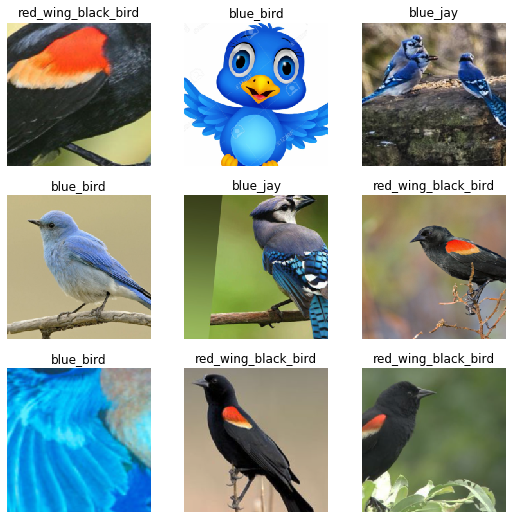

In [0]:
dbunch.show_batch(max_n=9)

In [0]:
dbunch.vocab

(#3) [blue_bird,blue_jay,red_wing_black_bird]

## Train model

In [0]:
learn = cnn_learner(dbunch, resnet34, pretrained=True, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.336276,1.784501,0.735294,00:06
1,2.077144,1.252749,0.588235,00:07
2,1.987740,1.183462,0.529412,00:06
3,1.948971,1.185183,0.558824,00:07


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

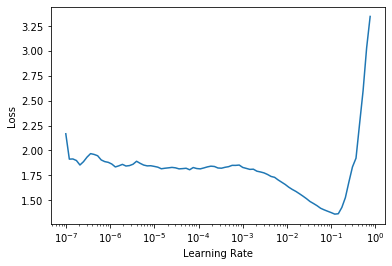

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(2, lr_max=slice(3e-3, 3e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.731745,0.587902,0.176471,00:07
1,1.194489,0.465058,0.176471,00:07


In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

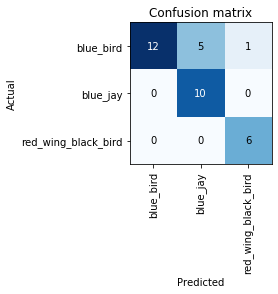

In [0]:
interp.plot_confusion_matrix()

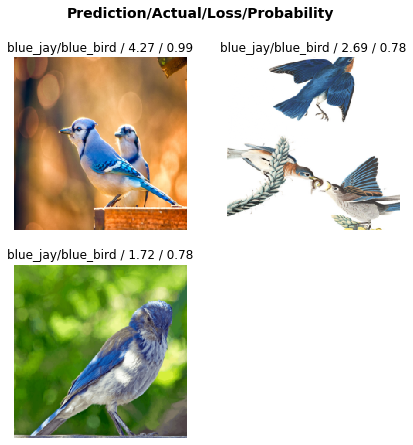

In [0]:
interp.plot_top_losses(3, figsize=(7,7))